**Table of contents**<a id='toc0_'></a>    
- [Import Required Library](#toc1_1_)    
- [Settings](#toc1_2_)    
- [Define all utility function](#toc1_3_)    
- [Preprocess the dataset](#toc1_4_)    
  - [Split the dataset into training and testing dataset](#toc1_4_1_)    
  - [Data Augmentation in Training Dataset](#toc1_4_2_)    
  - [Show the outcome of difference image enhancement technique](#toc1_4_3_)    
- [Load the preprocessed train dataset](#toc1_5_)    
- [Find Eigenfaces](#toc1_6_)    
  - [Show the first 10 Eigenfaces obtained by eigendecomposition](#toc1_6_1_)    
  - [Compare some original face and face reconstruced from the low dimensional space](#toc1_6_2_)    
- [Build, train and evaluate face classifiers](#toc1_7_)    
- [Real-time Face Recognition System](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import Required Library](#toc0_)

In [1]:
### Library required to run the code
# !pip install -U scikit-learn
# !pip install numpy matplotlib pandas
# !pip install xgboost catboost lightgbm

In [2]:
import numpy as np
import os                       # To get the image filename
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt # To plot out the image
import pandas as pd             # To visualize the result in dataframe

# To import 10 difference classifiers for testing 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

np.random.seed(0)               # Set random seed so the result is deterministic

## <a id='toc1_2_'></a>[Settings](#toc0_)

In [3]:
IMAGE_DIR           = "Face_Image"
PROCESSED_IMAGE_DIR = "Face_Image_Train_Processed"
TRAINING_IMG_DIR    = "Face_Image_Train"
TESTING_IMG_DIR     = "Face_Image_Test"
IMAGE_SIZE          = (100,100)
IMAGE_ENHANCE_METHOD= "Gaussian"  # Can be ["Gaussian", "Laplacian", "Histogram Equalization"]
RESIZE_FIRST        = False    # If True, it will resize the image to IMAGE_SIZE before image enhancement
k                   = 6        # k for k-NN, k=1 will be NCC

os.makedirs(PROCESSED_IMAGE_DIR, exist_ok=True)
os.makedirs(TRAINING_IMG_DIR, exist_ok=True)
os.makedirs(TESTING_IMG_DIR, exist_ok=True)

## <a id='toc1_3_'></a>[Define all utility function](#toc0_)

In [4]:
""" Function to detect the face using cascade classifier and return the detected face"""
def crop_face(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale image
    xmls = ['haarcascade_frontalface_alt.xml', 
            'haarcascade_frontalface_alt2.xml', 
            'haarcascade_frontalface_alt_tree.xml', 
            'haarcascade_frontalface_default.xml']
    
    for xml in xmls:
        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + xml)
        faces = faceCascade.detectMultiScale(img,
                                             scaleFactor=1.1,
                                             minNeighbors=5,
                                             minSize=(60, 60),
                                             flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces) != 0:
            break
    
    if len(faces) == 0:
        print("Failed to detect face")
        cv2.imshow("Undetectable face", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return 
    
    for (x,y,w,h) in faces:
        detected_face = img[y:y+h, x:x+w]
        return detected_face
    

"""Function to load numpy array from filename"""
def get_numpy_array(filename):
    with open(f'{PROCESSED_IMAGE_DIR}/{filename}.npy', 'rb') as f: 
        a = np.load(f)
    return a

In [5]:
""" Function for image enhancement 
1. Gaussian Smoothing
2. Histogram equalisation (Non-linear stretching)
3. Image sharpening with Laplacian filter
"""

def gaussian_smoothing(img, size, sigma):
    """
    Generate a Gaussian kernel, the calculation for each entry involves only the exponential term

    Parameters:
        size (int): The size of the kernel (odd number).
        sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
        np.ndarray: A 2D array representing the Gaussian kernel.
    """
    kernel = np.fromfunction(
        lambda x, y: np.exp(-((x - size//2)**2 + (y - size//2)**2) / (2*sigma**2)), 
        (size, size))
    kernel /= kernel.min()
    kernel /= np.sum(kernel)
    
    smoothed_img = cv2.filter2D(img.astype(np.float32), ddepth=-1, kernel=kernel)
    return smoothed_img

    
def histogram_equalise(img):
    pixel_range = list(range(256))
    uniques, counts = np.unique(img, return_counts=True)

    cumulative_sum = np.cumsum(counts)
    cumulative_mean = np.cumsum(np.ones(len(pixel_range)) * counts.sum() / len(pixel_range)) # {mean, mean, mean, ....} with length = 256 

    r = dict(zip(uniques, cumulative_sum))       # {existing pixel: cumulative frequency}
    s = dict(zip(pixel_range, cumulative_mean))  # {each pixel (0~255): cumulative mean}

    for pixel in pixel_range: 
        if pixel not in r.keys(): 
            r[pixel] = 0    # fill in the non-existing pixel and assign freq=0
        
    pixel_changer = {x:x for x in pixel_range}   # {original pixel: target pixel)
    for pixel in r: 
        if r[pixel] != 0: 
            # print(f"Updating pixel {pixel}")
            target_pixel = find_pixel_with_min_diff(pixel, r[pixel], s)
            pixel_changer[pixel] = target_pixel
            # print(f"result: {pixel} --> {target_pixel}")
    del r
    del s
    
    # print("reached here")
    equalised_img = np.select(
        [img == pixel for pixel in pixel_changer],
        [pixel for pixel in pixel_changer.values()],
        img
    )
    return equalised_img.astype(np.uint8)


# A helper function that is used to find the pixel in cumulative mean that has min freq difference from current pixel freq  
def find_pixel_with_min_diff(current_pixel, freq, cumulative_mean_dict):
    diff = np.inf
    target_pixel = current_pixel
    for pixel in cumulative_mean_dict: 
        # print(f"Now solving for pixel {pixel}")
        if abs(freq - cumulative_mean_dict[pixel]) <= diff:
            # print(f"diff: {diff} --> ", end="")
            diff = abs(freq - cumulative_mean_dict[pixel])
            # print(diff)
            # print()
            target_pixel = pixel
    return target_pixel


def laplacian_sharpening(img):
    kernel = np.array([[-1,-1,-1],
                       [-1, 8,-1],
                       [-1,-1,-1]])
   
    # kernel = np.array([[0, -1, 0],
    #                     [-1,4, -1],
    #                     [0, -1,-0]])
    img = img.astype(np.uint8)
    filtered_img  = cv2.filter2D(img, ddepth=-1, kernel=kernel)
    sharpened_img = cv2.add(img, filtered_img)
    return sharpened_img


def image_enhancement(img, gaussian_kernel_size=5, sigma=2, img_enhance_method=IMAGE_ENHANCE_METHOD):  
    assert img_enhance_method in ["Gaussian", "Laplacian", "Histogram Equalization"]
    if img_enhance_method == "Gaussian":
        return gaussian_smoothing(img, gaussian_kernel_size, sigma)
    elif img_enhance_method == "Laplacian":    
        return laplacian_sharpening(img)
    else:
        return histogram_equalise(img)

In [6]:
""" Functions for data augmentation """
def flip_image(img, orientation): # flip the input image horizontally or vertically 
    assert orientation.lower() in ["horizontal", "vertical"],\
    f"'orientation' arguement takes only 'horizontal' and 'vertical', but found {orientation}"
    return cv2.flip(img, flipCode=1 if orientation=='horizontal' else 0)


def rotate_image(img, angle):   # rotate the input image by a given angle  
    h, w = img.shape[:2]
    M    = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    return cv2.warpAffine(img, M, (w, h))


def generate_augmented_image(img, saved_folder, name, rotation_angles=[10, 20, 30], flip_orientation="horizontal"): 
    # Flip the image and save into saved_folder
    file_dir    = f"{saved_folder}/{name.split('.')[0] + f'-flipped-{flip_orientation}.' + name.split('.')[-1]}"
    flipped_img = flip_image(img, flip_orientation)
    cv2.imwrite(file_dir, flipped_img)
    
    # Rotate the image in difference angle (in both clockwise and counter-clockwise) and save to the saved_folder'
    for i, angle in enumerate(rotation_angles): 
        cv2.imwrite(f"{saved_folder}/{name.split('.')[0] + f'-rotated-{i+1}-acw.' + name.split('.')[-1]}", rotate_image(img, angle))
        cv2.imwrite(f"{saved_folder}/{name.split('.')[0] + f'-rotated-{i+1}-cw.' + name.split('.')[-1]}" , rotate_image(img, -angle))

## <a id='toc1_4_'></a>[Preprocess the dataset](#toc0_)

### <a id='toc1_4_1_'></a>[Split the dataset into training and testing dataset](#toc0_)
* For each of the person, 1 of the image is extracted and placed into testing dataset

In [7]:
if len(os.listdir(TRAINING_IMG_DIR)) == 0 and len(os.listdir(TESTING_IMG_DIR)) == 0:
    # Extract the name of each person
    persons = np.unique([name[:name.rindex("_")] for name in os.listdir(IMAGE_DIR)]).tolist()
    print("Number of unique person:", len(persons))

    # Select one image of each person and use it for testing, while the remaining will be used for training
    for person in persons:
        images = {img: cv2.imread(f"{IMAGE_DIR}/{img}") for img in os.listdir(IMAGE_DIR) if img.startswith(person)}
        test_image_name = np.random.choice(list(images.keys()))
        test_image = images.pop(test_image_name)
        cv2.imwrite(f"{TESTING_IMG_DIR}/{test_image_name}", test_image)
        
        for img in images:
            cv2.imwrite(f"{TRAINING_IMG_DIR}/{img}", images[img])
else: 
    print("Training folder or testing folder contains images")
    
print("Number of training images:", len(os.listdir(TRAINING_IMG_DIR)))
print("Number of testing  images:", len(os.listdir(TESTING_IMG_DIR)))

Number of unique person: 29


Number of training images: 111
Number of testing  images: 29


### <a id='toc1_4_2_'></a>[Data Augmentation in Training Dataset](#toc0_)

In [8]:
angles               = [5, 10, 15]    # angles for rotation
gaussian_kernel_size = 3    
sigma                = 1

# Process the images and generate augmentation
for face_dir in tqdm(os.listdir(TRAINING_IMG_DIR)):
    if face_dir.endswith(".png") or face_dir.endswith(".jpg") or face_dir.endswith(".jpeg"):
        img = cv2.imread(f'{TRAINING_IMG_DIR}/{face_dir}') # Read the image
        
        detected_face = crop_face(img)
        # Image enhancement: original image --> sharpening --> non-linear stretching(HE) --> smoothing
        
        # resize to IMAGE_SIZE before enhancing
        if RESIZE_FIRST:
            enhanced_image = image_enhancement(cv2.resize(detected_face, IMAGE_SIZE), gaussian_kernel_size, sigma)
        
        # resize to IMAGE_SIZE after enhacing
        else: 
            enhanced_image = cv2.resize(image_enhancement(detected_face, gaussian_kernel_size, sigma), IMAGE_SIZE)
            
        cv2.imwrite(f"{PROCESSED_IMAGE_DIR}/{face_dir.split('.')[0] + '-processed.' + face_dir.split('.')[-1]}", enhanced_image)
        
        generate_augmented_image(enhanced_image, saved_folder=PROCESSED_IMAGE_DIR, name=face_dir, rotation_angles=angles)

100%|██████████| 111/111 [00:07<00:00, 15.82it/s]


### <a id='toc1_4_3_'></a>[Show the outcome of difference image enhancement technique](#toc0_)

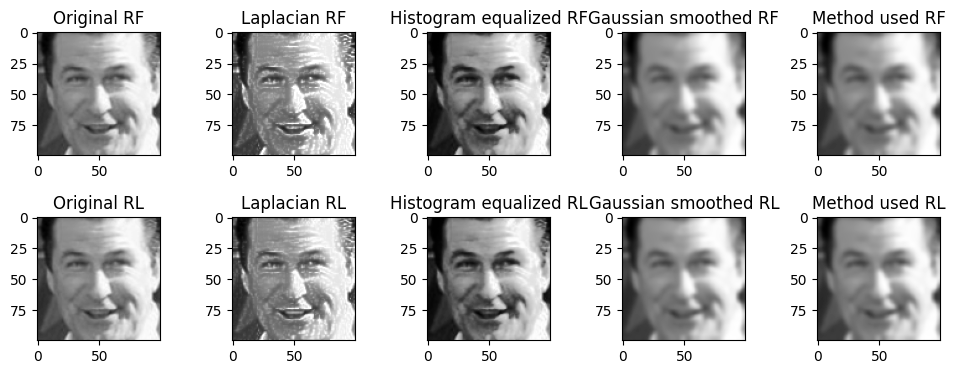

In [9]:
# Read 1 sample image and crop the face
sample_img = cv2.imread(f'{TRAINING_IMG_DIR}/Alec_Baldwin_2.jpg') 
sample_img = crop_face(sample_img)

_, ax      = plt.subplots(2, 5, figsize = (12,4))
plt.subplots_adjust(wspace = 0.3, hspace = .5)

for i in range(2):
    list_title = ["Original", "Laplacian", "Histogram equalized", "Gaussian smoothed", "Method used"]
    
    # Resize to IMAGE_SIZE before image enhancement (Resize First)
    if i == 0: 
        list_title = [title_ + " RF" for title_ in list_title]
        resize_img = cv2.resize(sample_img, IMAGE_SIZE)
        list_imgs  = [resize_img, 
                      laplacian_sharpening(resize_img), 
                      histogram_equalise(resize_img), 
                      gaussian_smoothing(resize_img, 7, 2),
                      image_enhancement(resize_img, gaussian_kernel_size=7, sigma=2)]
    
    # Resize to IMAGE_SIZE after image enhancement (Resize Last)
    else:       
        list_title = [title_ + " RL" for title_ in list_title]
        list_imgs  = [sample_img, 
                      laplacian_sharpening(sample_img), 
                      histogram_equalise(sample_img), 
                      gaussian_smoothing(sample_img, 7, 2),
                      image_enhancement(sample_img, gaussian_kernel_size=7, sigma=2)]
        list_imgs = [cv2.resize(img, IMAGE_SIZE) for img in list_imgs]
    
    # Plot out the images
    for j, (title, img) in enumerate(zip(list_title,list_imgs)):
        ax[i][j].set_title(title)
        ax[i][j].imshow(img, cmap='gray')

* From the figure above, there is limited effect on detected face when the image is resized before image enhancement (RF) or image is resized after image enhancement (RL). This may due to the detected face is very small and have shape near to IMAGE_SIZE. Therefore, in our case, we use RL as resize image with higher quality into smaller size intuitively will have a better outcome than using the image with lower quality

## <a id='toc1_5_'></a>[Load the preprocessed train dataset](#toc0_)

In [10]:
image_dataset = []
list_label    = []
for face_dir in os.listdir(PROCESSED_IMAGE_DIR):  
    if face_dir.endswith(".png") or face_dir.endswith(".jpg") or face_dir.endswith(".jpeg"):
        img   = cv2.imread(f'{PROCESSED_IMAGE_DIR}/{face_dir}', cv2.IMREAD_GRAYSCALE) 
        label = face_dir[:face_dir.rindex("_")]
        
        # Flatten the image
        img = img.flatten()
        
        # Add 1 dimension at front and Append the image into dataset
        image_dataset.append(img[None,:])
        list_label.append(label)

list_label = np.array(list_label)
D = np.concatenate(image_dataset, axis=0)
print(D.shape)

(888, 10000)


## <a id='toc1_6_'></a>[Find Eigenfaces](#toc0_)

In [11]:
%%time

mean_features = np.mean(D, axis=0)        # Find the mean for each features
D_mean        = D - mean_features           # Find the mean-center image dataset
cov    = D_mean.T @ D_mean / (D.shape[0]) # Compute the covariance matrix
threshold = 1

eigenvalue, eigenvector = np.linalg.eigh(cov) # Compute eigenvalue and eigenvector using CPU

# sorting based on decreasing eigenvalues (largest eigenvalue at left) 
eigenvector = np.array([x for _,x in sorted(zip(eigenvalue,eigenvector.T),reverse=True)]).T
eigenvalue  = np.array(sorted(eigenvalue,reverse=True))

# Get the index such that the eigenvalue > than a predefined threshold 
idx = eigenvalue > threshold                 
print(f"Number of eigenvalue that larger than threshold {threshold}: {idx.sum()}")

# Get the eigenfaces
low_dim_faces = D_mean @ eigenvector[:,idx]
print(f"The data have been reduce from shape {D_mean.shape} to {low_dim_faces.shape}")

# Save the mean_features and the eigenvector and the eigenfaces
for numpy_array, file_name in [[low_dim_faces, "low_dim_faces"], [eigenvector[:,idx], "eigenvector"], 
                               [mean_features,"mean_features"], [list_label, "list_label"]]:
    with open(f'{PROCESSED_IMAGE_DIR}/{file_name}.npy', 'wb') as f:
        np.save(f, numpy_array)

Number of eigenvalue that larger than threshold 1: 887
The data have been reduce from shape (888, 10000) to (888, 887)
CPU times: total: 9min 20s
Wall time: 1min 39s


### <a id='toc1_6_1_'></a>[Show the first 10 Eigenfaces obtained by eigendecomposition](#toc0_)

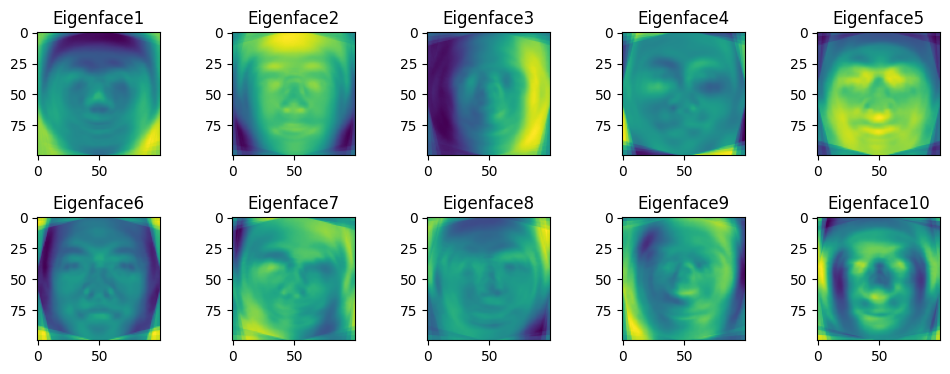

In [12]:
_, ax = plt.subplots(2, 5, figsize = (12,4))
plt.subplots_adjust(wspace = 0.3, hspace = .5)

for i in range(0, 10):
    ax[i // 5, i % 5].imshow(eigenvector[:,i].reshape(IMAGE_SIZE))
    ax[i // 5, i % 5].set_title(f"Eigenface{i+1}")

### <a id='toc1_6_2_'></a>[Compare some original face and face reconstructed from the low dimensional space](#toc0_)

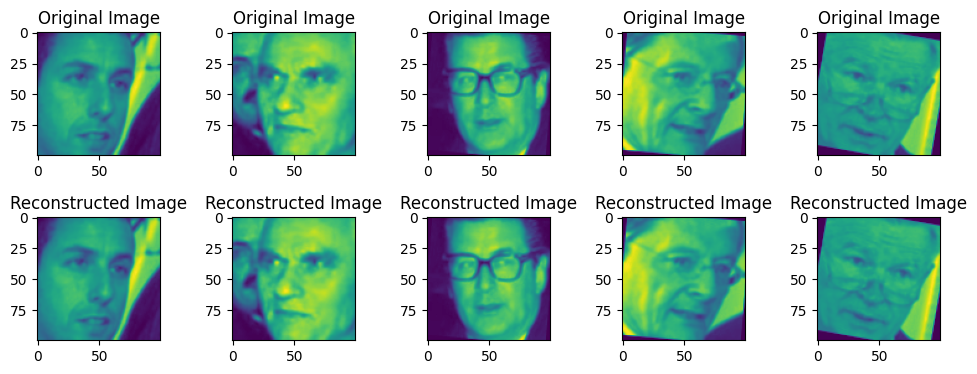

In [13]:
num_data_show = 5
rand_num      = np.random.randint(D.shape[0], size=num_data_show)
_, ax         = plt.subplots(2, num_data_show, figsize = (12,4))
plt.subplots_adjust(wspace = 0.3, hspace = .5)

for i, num in enumerate(rand_num):
    ax[0][i].imshow(D[num].reshape(IMAGE_SIZE))
    ax[0][i].set_title(f"Original Image")

    ax[1][i].imshow((low_dim_faces[num] @ eigenvector[:,idx].T + mean_features).reshape(IMAGE_SIZE))
    ax[1][i].set_title(f"Reconstructed Image")

* From the figure above, there is nearly no difference between original image and reconstructed image using 887 dimensions. This show that PCA's capability in represent the data in lower dimension while retaining most of the important information. 

## <a id='toc1_7_'></a>[Build, train and evaluate face classifiers](#toc0_)

In [14]:
Xtrain = get_numpy_array("low_dim_faces")
ytrain = np.array(list_label)[:, None]
Xtest = [cv2.imread(f"{TESTING_IMG_DIR}/{img}") for img in os.listdir(TESTING_IMG_DIR)]
ytest = np.array([name[:name.rindex("_")] for name in os.listdir(TESTING_IMG_DIR)])[:, None]

print("Number of unique label in train dataset:", len(np.unique(ytrain)))
print("Number of unique label in test dataset:", len(np.unique(ytest)))

Number of unique label in train dataset: 29
Number of unique label in test dataset: 29


In [15]:
%%time 
# Standardized features and encode the label into number
sc = StandardScaler()
le = LabelEncoder()

Xtrain_transformed = sc.fit_transform(Xtrain)
ytrain_le          = le.fit_transform(ytrain.flatten())
ytest_le           = le.transform(ytest.flatten())

# Declare all classifier
knnc    = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
log_reg = LogisticRegression(penalty='l2', n_jobs=-1)
gnb     = GaussianNB()
svc     = SVC()
lin_dis = LinearDiscriminantAnalysis()

rfc     = RandomForestClassifier(n_jobs=-1)
adabc   = AdaBoostClassifier(n_estimators=30)
xgbc    = XGBClassifier(n_estimators=30, n_jobs=-1)
cbc     = CatBoostClassifier(n_estimators=30, verbose=0)
lgbmc   = LGBMClassifier(n_estimators=30, n_jobs=-1, verbose=0)

# Train all classifiers
models_name = ['knnc', 'log_reg', 'gnb', 'svc', 'rfc', 'xgbc', 'cbc', 'lgbmc', 'lin_dis', "adabc"]
models      = [knnc, log_reg, gnb, svc, rfc, xgbc, cbc, lgbmc, lin_dis, adabc]
all_models = dict(zip(models_name, models))
for model_name in tqdm(all_models):
    all_models[model_name] = all_models[model_name].fit(Xtrain_transformed, ytrain_le)

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [03:00<02:30, 50.28s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 10/10 [03:50<00:00, 23.06s/it]

CPU times: total: 33min 58s
Wall time: 3min 50s


In [16]:
def predict_test_data(Xtest, model):
    ypred = []
    for test_img in Xtest:
        # step1: face detection and resize
        detected_face = crop_face(test_img)
        if detected_face is None:
            return []
        
        # step2: enhance image
        if RESIZE_FIRST: 
            enhanced_image = image_enhancement(cv2.resize(detected_face, IMAGE_SIZE), gaussian_kernel_size, sigma)
        else: 
            enhanced_image = cv2.resize(image_enhancement(detected_face), IMAGE_SIZE, gaussian_kernel_size, sigma)
        
        # step3: PCA
        mean_centered = enhanced_image.flatten() - mean_features 
        pca_data      = mean_centered @ eigenvector
        
        # step4: predict
        prediction = model.predict([pca_data])
        ypred.append(prediction[0])
    
    return np.round(ypred)

low_dim_faces = get_numpy_array("low_dim_faces")
eigenvector   = get_numpy_array("eigenvector")
mean_features = get_numpy_array("mean_features")
list_label    = get_numpy_array("list_label")
acc_list = dict()
for model in tqdm(all_models):
    ypred = predict_test_data(Xtest, all_models[model])
    acc_list[model] = accuracy_score(ypred, ytest_le)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


In [17]:
result_df = pd.DataFrame(index=acc_list.keys())
result_df["Test accuracy"] = acc_list.values()
result_df

,Test accuracy
knnc,0.413793
log_reg,0.344828
gnb,0.068966
svc,0.034483
rfc,0.241379
xgbc,0.206897
cbc,0.241379
lgbmc,0.206897
lin_dis,0.206897
adabc,0.068966


In [18]:
def find_best_k(Xtest, kmax=100):
    all_k = np.array(range(kmax)) + 1
    acc = []
    for k in tqdm(all_k):
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(Xtrain_transformed, ytrain_le)
        ypred = predict_test_data(Xtest, knn)
        acc.append(accuracy_score(ypred, ytest_le))
    return np.argmax(acc) + 1, np.max(acc)

best_k, best_acc = find_best_k(Xtest, kmax=10)
print("Best k found   =", best_k)
print(f"best accuracy =", best_acc)

100%|██████████| 10/10 [00:22<00:00,  2.27s/it]

Best k found   = 10
best accuracy = 0.4482758620689655


In [19]:
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(Xtrain_transformed, ytrain_le)
ypred_knn = predict_test_data(Xtest, knn)
print(f"best accuracy: {accuracy_score(ypred_knn, ytest_le)}")

best accuracy: 0.4482758620689655


Number of correct prediction with the best model: 13 out of 29


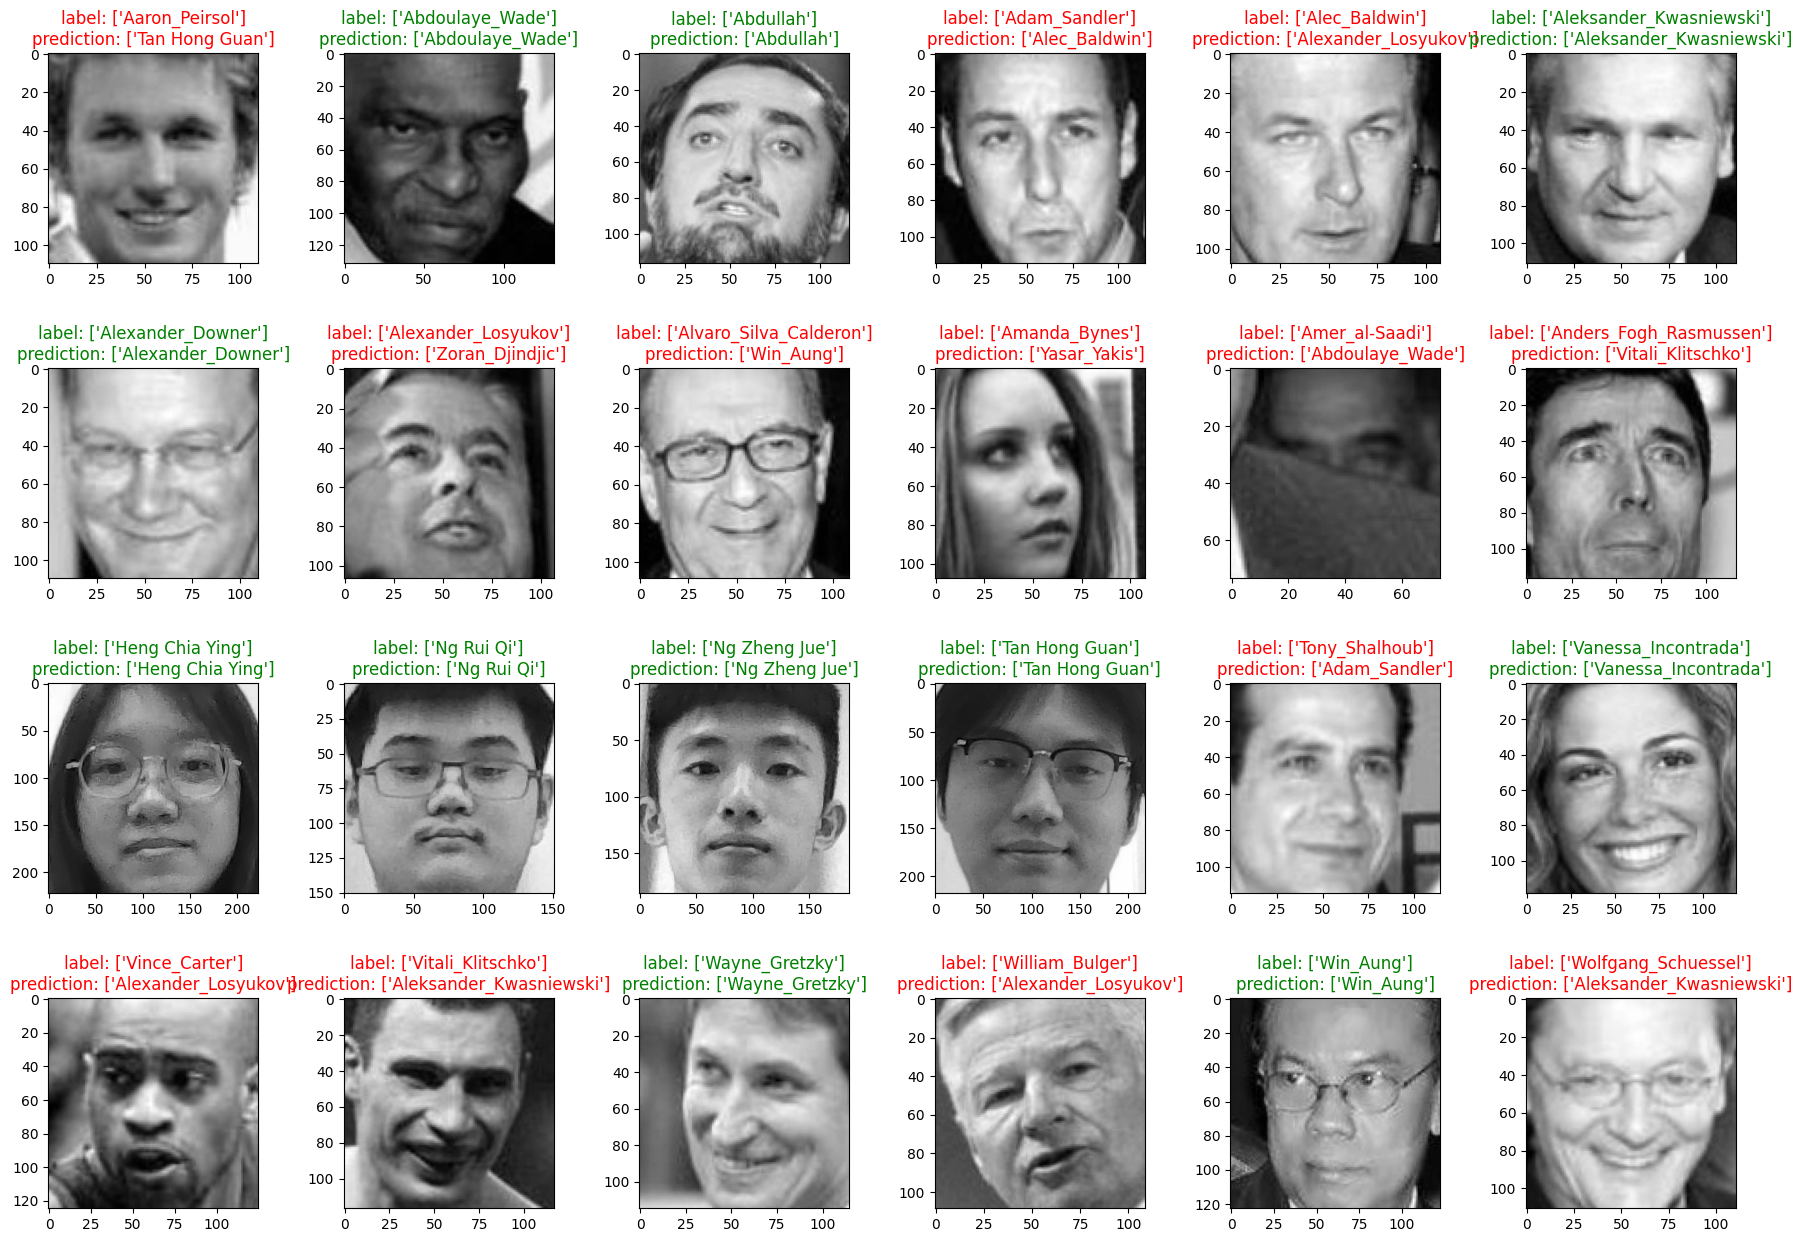

In [20]:
nrows = 4
ncols = 6
_, ax = plt.subplots(nrows,ncols, figsize=(22,15))
plt.subplots_adjust(wspace = 0.3, hspace = .5)

print(f"Number of correct prediction with the best model: {np.sum(ypred_knn == ytest_le)} out of {len(ytest)}")
count = 0
for i in range(nrows):
    for j in range(ncols):
        label = ytest[count]
        prediction = le.inverse_transform([ypred_knn[count]])
        color = 'green' if label == prediction else 'red'
        ax[i, j].set_title(f"label: {label}\nprediction: {prediction}", color=color)
        ax[i, j].imshow(crop_face(Xtest[count]), cmap='gray')
        count +=1 

* Among 10 classifiers, kNN with k=6 tends to be the best method in face classification on dataset after perform PCA. Therefore, in real-time face recognition system, kNN with k=6 will be used to perform face classification

## <a id='toc1_8_'></a>[Real-time Face Recognition System](#toc0_)

In [21]:
# Load the mean_features and the eigenvector and the eigenfaces
low_dim_faces = get_numpy_array("low_dim_faces")
eigenvector   = get_numpy_array("eigenvector")
mean_features = get_numpy_array("mean_features")
list_label    = get_numpy_array("list_label")

print(low_dim_faces.shape, eigenvector.shape, mean_features.shape, list_label.shape)

(888, 887) (10000, 887) (10000,) (888,)


In [22]:
# Real-time obtain the image, classify and label it
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
video_capture = cv2.VideoCapture(0)
while True:
    ret, frame = video_capture.read() # Capture frame-by-frame

    # Data preprocessing
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h),(0,255,0), 2) # Draw a rectangle at the detected face

        # Data Preprocessing
        detected_face = img[y:y+h, x:x+w]                    # Extract the face from grayscale image
        detected_face = image_enhancement(detected_face)     # Perform image enhancement on the detected face
        detected_face = cv2.resize(detected_face, IMAGE_SIZE)# Resize the face
        detected_face = detected_face.flatten()[None, :]     # Reshape to [1, IMAGE_SIZE[0]*IMAGE_SIZE[1])
        
        # Recognize the face
        detected_face = (detected_face - mean_features) @ eigenvector  # Transform the data into lower dimension using pre-computed eigenvector and mean
        detected_face = detected_face.flatten()

        # Compute the distance between detect face and 
        list_dist = []
        for face_in_dataset in low_dim_faces:
            list_dist.append((face_in_dataset*detected_face).sum() - 1/2*(face_in_dataset*face_in_dataset).sum())
        
        # Get k name with largest distance and its corresponding distance
        list_dist   = np.array(list_dist)
        indices     = np.argsort(list_dist)
        k_face_name = list_label[indices[-k:]] 
        k_dist      = list_dist[indices[-k:]]  
        
        # Get the number of count for each of the unique name
        unique_name = np.unique(k_face_name)
        list_count  = [(name_ == k_face_name).sum() for name_ in unique_name]
        
        if list_count.count(np.max(list_count)) == 1:     # If only 1 name with the maximum number of votes, obtain the face name by majority vote
            face_name = unique_name[np.argmax(list_count)]  
        else:                                             # If > 1 name with the maximum number of votes, obtain the face name by average distance
            weight_name = [(k_dist[name_ == k_face_name]).sum() / (name_ == k_face_name).sum() 
                            for name_ in unique_name]   # Average weight for each unique name 
            face_name   = unique_name[np.argmax(weight_name)] 
        
        
        # Place the text 
        frame = cv2.putText(frame, face_name, (int(x), int(y-0.1*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.7,  
                            (0, 0, 255) , 2, cv2.LINE_AA, False) 

    # Show the image
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
video_capture.release()
cv2.waitKey(0)
cv2.destroyAllWindows()